In [2]:
import numpy as np



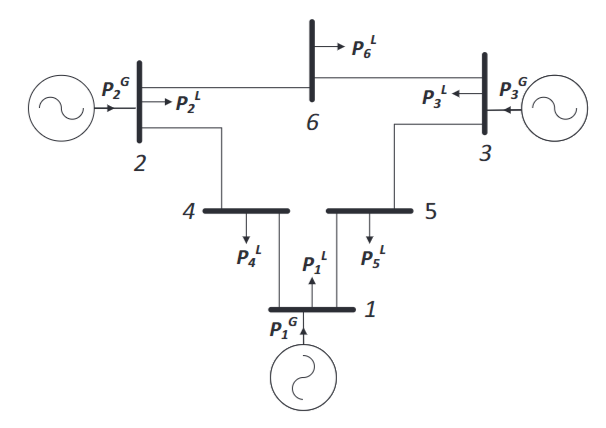


In [5]:
NG= 3
NL= 6

IMat= np.eye(NG)
MMat= np.diag([0.125, 0.034, 0.016]) # diagonal matrices filling with generator inertia
DGMat= 
print(MMat)

[[0.125 0.    0.   ]
 [0.    0.034 0.   ]
 [0.    0.    0.016]]
